# Multiphase Example
## OCP Description
Let's introduce a second phase to the previous example where the block will have to return to it's original position. Because we know friction will switch direction when we slide the block back, the equations of motion change. Since phase A will not change, lets copy everything up until we start initiating the objective function. 

In [40]:
# 1D Blockslide
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import pycollo

# State variables
x = sym.Symbol("x")  # Position (m) of the block horizontally from the origin (x-axis)
dx = sym.Symbol("dx")  # Velocity (m/s) of the block horizontally (x-axis)
# Control variables
Fx = sym.Symbol("Fx")  # Force (N) applied to the block horizontally (x-axis)

# Static parameter variable
g = sym.Symbol("g")  # Gravitational acceleration (m/s^2)
m = sym.Symbol("m")  # Mass (kg) of the block
mu = sym.Symbol("mu") # Coefficient of friction (-)

# Problem instantiation
problem = pycollo.OptimalControlProblem(
    name="Simple Block Slide",
    parameter_variables= (m,mu))
    
problem.bounds.parameter_variables = [[1,2], [0.5,1]]
problem.guess.parameter_variables = [1.5, 0.75]
problem.auxiliary_data = {g: 9.81}

phase_A = problem.new_phase(name="A")
phase_A.bounds.initial_time = 0.1
phase_A.bounds.final_time = [0.1, 10]
phase_A.guess.time = [0.1, 1]

phase_A.state_variables = [x, dx]
phase_A.bounds.state_variables = [[-3,3],[-50,50]]
phase_A.bounds.state_variables = {
    x: [-3, 3],
    dx: [-50, 50],}
phase_A.bounds.initial_state_constraints = {
    x: 0,
    dx: 0,}
phase_A.bounds.final_state_constraints = {
    x: 1,
    dx: 0,}
phase_A.guess.state_variables = [[0, 0], [0, 0]]

phase_A.control_variables = [Fx]
phase_A.bounds.control_variables = {
    Fx: [-50, 50],}
phase_A.guess.control_variables = [
        [0, 0],]

phase_A.state_equations = {
    x: dx,
    dx: Fx / m - m*g*mu,}

phase_A.integrand_functions = [Fx ** 2]
phase_A.bounds.integral_variables = [[0, 1000]]
phase_A.guess.integral_variables = [0]

## New phase
Now we can copy the previous phase completely to initiate a new phase completely the same. When doing this make sure you overwrite everything that changes in this next phase. It is real easy to make mistakes like this and it is recommended to write out the full phase description as depicted above.

In [41]:
phase_B = problem.new_phase_like(
    phase_for_copying=phase_A,
    name="B",)

Now we can start overwriting everything that will be different from the previous phase:

- Time 
    Phase B initial time can start any moment within bounds, final time the same
- Initial and final state constraints
    The block starts at final state of phase A, and will end at 0.
- State equations
    Friction changes sign

In [42]:
# Time 
phase_B.bounds.initial_time = [0, 10]
phase_B.bounds.final_time = [0, 10]
phase_B.guess.time = [1, 2]

# Initial and final state constraints
phase_B.bounds.initial_state_constraints = {
    x: 1,
    dx: 0,}
phase_B.bounds.final_state_constraints = {
    x: 0,
    dx: 0,}

# State equations
phase_B.state_equations = {
    x: dx,
    dx: Fx / m + m*g*mu,}

## Endpoint constraints
To make sure all variables are continious, sometimes endpoint constraints need to be implemented. Endpoint constraints are constraintes which exist of initial and final variables. When final and initial states are not bound to a single value, phase A final states should match phase B initial states to make the states continious. In this example, the states are constrainted to be continious due to the initial and final state constraints of both phases. Time variables are not constrained to be continious (yet) thus we can implement the following inequality constraint (final time phase A = initial time phase B -> final time phase A - initial time phase B = 0):

In [43]:
problem.endpoint_constraints = [
    phase_A.final_time_variable - phase_B.initial_time_variable,]
    
problem.bounds.endpoint_constraints = [
    0,]

## Objective function - multiphase
Now the objective to minimize input force Fx should als be updated to consider both phases, the integrand functions are created with the copying of the new phase but are yet to be implemented in the objective:

In [44]:
problem.objective_function = (
    phase_A.integral_variables[0] + phase_B.integral_variables[0])
# Bug
phase_B.guess.integral_variables = 0

### Solve


Initialising optimal control problem.

Phase variables and equations checked.
Pycollo variables and constraints preprocessed.
Backend initialised.
Bounds checked.
Problem scaling initialised.
Quadrature scheme initialised.
Backend postprocessing complete.
Initial mesh created.
Initial guess checked.

Initialising mesh iteration #1.

Guess interpolated to iteration mesh in 1.61ms.
Scaling initialised in 122.67us.
Initial guess scaled in 5.42us.
Scaling generated in 3.94ms.
NLP generated in 77.85ms.
Mesh-specific bounds generated in 268.33us.

Mesh iteration #1 initialised in 83.80ms.


Solving mesh iteration #1.

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     1061
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      312

Total number of variables............................:      185
                     variables with only lower bou

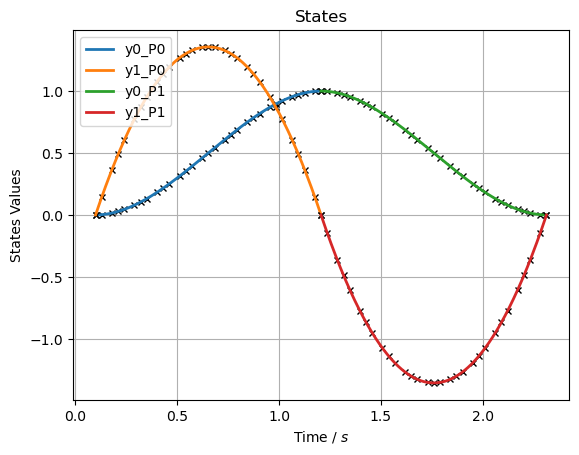

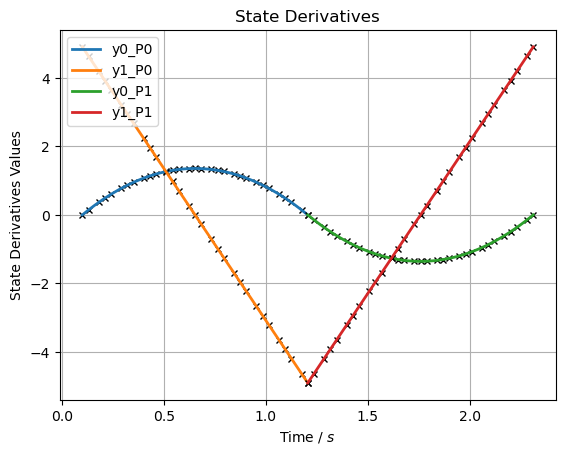

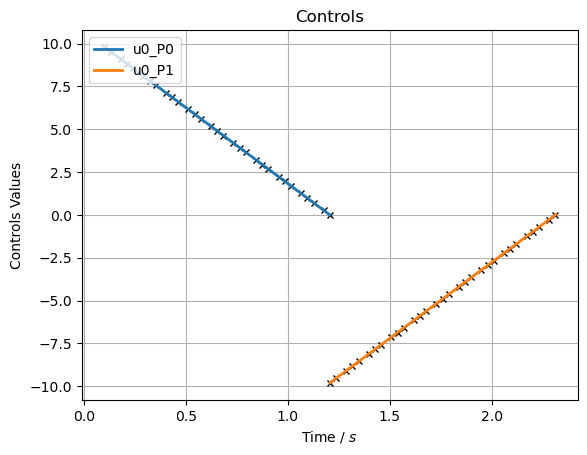

Mesh tolerance met in mesh iteration 1.


Optimal control problem sucessfully solved.

Final Objective Function Evaluation: 70.9582



In [45]:
problem.settings.display_mesh_result_graph = True
problem.initialise()
problem.solve()

### Solution
To acces the found solution you can use `problem.solution.{}`. The most frequently used options are:
- `problem.solution.state`
    Outputs a tuple where each index represents the solution per phase. The solution per phase is presented by an array for each state variable where the indices of these arrays represent the solution at the given collocation point. The solutions are ordered the same way you supplied the state variables.For example: In this case there are 2 phases (A and B), and 2 states (x, dx) with each 31 collocation points. Thus `problem.solution.state[0][1][23]` will output the 23rd collocation point of state variable 'dx' of phase 'A'. 

In [46]:
print(problem.phases)
print(phase_A.state_variables)
print(np.shape(problem.solution.state))
print(problem.solution.state[0][1][23])

{'A': Phase(OptimalControlProblem('Simple Block Slide'), phase_number=0), 'B': Phase(OptimalControlProblem('Simple Block Slide'), phase_number=1)}
(x, dx)
(2, 2, 31)
0.95381151865818


- `problem.solution.control`
    Shows solution of all control variables indexed the same as shown above
- `problem.solution.parameter`
    Outputs 1D numpy array of parameters in the order you have supplied them to the OCP.
- `problem.solution.integral`
    Outputs a tuple where each index represents the solution per phase. The solution per phase is presented by an array where each element represents the solution of the integrand function in that phase. For example in this case there is only one integrand function, the first array is the solution for phase A and the second array for phase B:

In [47]:
print(phase_A.integrand_functions)
print(problem.solution.integral)

(Fx**2,)
(array([35.4791215]), array([35.4791215]))


- `problem.solution.\_time\_`\
    Outputs a tuple where each index represents the time per phase. The time per phase is a 1D array where every index indicates the time at that collocation point.
- `problem.solution.initial time`
    Outputs tuple of initial times per phase
- `problem.solution.final time`
    Outputs tuple of final times per phase